## Cancer Taxol Treatment Model

The goal of the notebook is to study practical identifiability of **Cancer Taxol Treatment Model** with *LikelihoodProfiler*. Identifiability of this model was analyzed in [Marisa C.Eisenberg, Harsh V.Jain. A confidence building exercise in data and identifiability](https://www.sciencedirect.com/science/article/pii/S0022519317303454). We have translated Marisa's Matlab model from [cancer-chemo-identifiability repo](https://github.com/marisae/cancer-chemo-identifiability) to [Julia language](https://julialang.org/). 
The model is defined by the following system of differential equations:

In [2]:
using DiffEqBase, OrdinaryDiffEq, Plots, NLopt, LikelihoodProfiler, DataFrames, Distributions
import Statistics: mean

# https://github.com/marisae/cancer-chemo-identifiability/blob/master/Profile%20Likelihood/testa0_de.m
function ode_func(du, u, p, t, drug)
    let (a0, ka, r0, d0, kd) = (p[1], p[2], p[3], p[4], p[5])

        K   = 10.515*100
        V0  = 1.3907*K
        lam = 9.5722

        theta = 10.

        # Values taken from 
        aRP  = 20.     # per day from Kim_PrlifQuies

        Ncel = u[1] + u[2] + u[3]
        Lfac = ((K-Ncel)^theta)/((V0^theta) + ((K-Ncel)^theta))

        arstexp = 3.
        adthexp = 4.

        arst = a0*(drug^arstexp)/(ka^arstexp + (drug^arstexp))
        adth = d0*(drug^adthexp)/(kd^adthexp + (drug^adthexp))
        arcv = r0

        # The differntial equations
        du[1] = -lam*u[1] + aRP*u[2]*Lfac - arst*u[1] + arcv*u[3]
        du[2] = 2*lam*u[1] - aRP*u[2]*Lfac
        du[3] = arst*u[1] - adth*u[3] - arcv*u[3]
    end
end;

Experimental datasets are also provided in [cancer-chemo-identifiability repo](https://github.com/marisae/cancer-chemo-identifiability/blob/master/Profile%20Likelihood/testa0_fit.m#L56-L105) for four drug doses (5, 10, 40, 100)

In [13]:
# https://github.com/marisae/cancer-chemo-identifiability/blob/master/Profile%20Likelihood/testa0_fit.m

# Data from Terzis et al. Brit J Cancer 1997;75:1744.
# From Bowman et al. Glia 1999;27:22, glioma cell volume is 0.916
# picoliters, 1 mm^3 = 1e6 pl or ~1.091 million cells

times = [0., 3., 6., 9., 12., 15.]   # days

dose = [5., 10., 40., 100.];    # dose in ng/ml

# Control data
Cell = [0.009, 0.050, 0.120, 0.189, 0.230, 0.260]*1091.0   # thousands of cells
Cerr = [0.006, 0.012, 0.010, 0.011, 0.011, 0.011]*1091.0   # thousands of cells

# 0.005 ug/ml Taxol
Cell005 = [0.009, 0.047, 0.089, 0.149, 0.198, 0.219]*1091.0   # thousands of cells
Cerr005 = [0.006, 0.013, 0.010, 0.011, 0.013, 0.010]*1091.0   # thousands of cells

# 0.010 ug/ml Taxol
Cell010 = [0.009, 0.043, 0.077, 0.093, 0.109, 0.128]*1091.0   # thousands of cells
Cerr010 = [0.006, 0.012, 0.013, 0.012, 0.014, 0.012]*1091.0   # thousands of cells

# 0.040 ug/ml Taxol
Cell040 = [0.009, 0.025, 0.047, 0.054, 0.076, 0.085]*1091.0   # thousands of cells
Cerr040 = [0.005, 0.010, 0.010, 0.011, 0.010, 0.010]*1091.0   # thousands of cells

# 0.100 ug/ml Taxol
Cell100 = [0.009, 0.025, 0.026, 0.028, 0.029, 0.031]*1091.0   # thousands of cells
Cerr100 = [0.006, 0.010, 0.009, 0.008, 0.011, 0.011]*1091.0   # thousands of cells

C005 = mean(Cell005)
C010 = mean(Cell010)
C040 = mean(Cell040)
C100 = mean(Cell100)

data = [Cell005/C005, Cell010/C010, Cell040/C040, Cell100/C100]
datamean = [C005, C010, C040, C100];

To visualize numerical simulations vs experimental data we can solve the ODE system and plot the results. Let's do it for  *dose=5*.   

In [23]:
# solver algorithm and tolerances
solver_opts = Dict(
    :alg => Vern7(),
    :reltol => 1e-7,
    :abstol => 1e-14
)

# initial values and parameters
# https://github.com/marisae/cancer-chemo-identifiability/blob/master/Profile%20Likelihood/testa0_soln.m#L3-L6
# https://github.com/marisae/cancer-chemo-identifiability/blob/master/Profile%20Likelihood/testa0_fit.m#L4

#P0 = 7.2700
#R0 = 2.5490

u0 = [7.2700, 2.5490, 0.]
p0 = [8.3170, 8.0959, 0.0582, 1.3307, 119.1363]

tspan = (0.,15.)

prob = ODEProblem((du,u,p,t)->ode_func(du,u,p,t,5.0), u0, tspan, p0)
sol = solve(
    prob, 
    solver_opts[:alg], 
    reltol=solver_opts[:reltol],
    abstol=solver_opts[:abstol],
    saveat=times
);

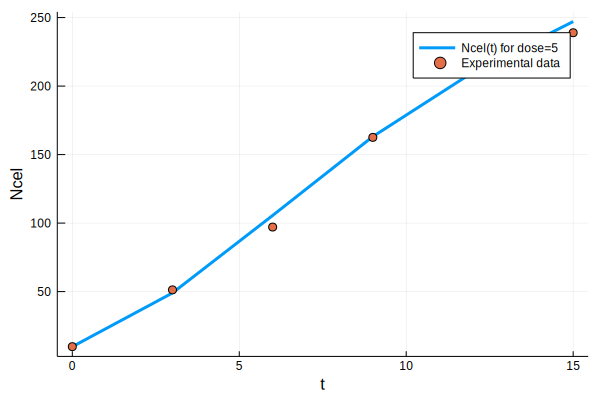

In [5]:
plot(sol.t, (sol[1,:]+sol[2,:]+sol[3,:]), xlabel = "t", ylabel = "Ncel", label="Ncel(t) for dose=5", line=3);
scatter!(times, Cell005, label = "Experimental data")

We need to define the likelihood function to run confidence intervals estimation. We use least-square fit as it was proposed in the original code:
$$ \Lambda = \sum_{i=1}^n \left( y(t_i) - data_i \right)^2 $$

Where
$n$ - number of observations (experimental data time points),
$data_i$ - experimental data,
$y(t_i)$ - numerical solution 

In [6]:
# https://github.com/marisae/cancer-chemo-identifiability/blob/master/Profile%20Likelihood/testa0_fit.m#L92
# https://www.mathworks.com/help/optim/ug/lsqcurvefit.html
function lsq_func(
    p;
    ode_func=ode_func,
    dose=dose,
    data=data,
    datamean=datamean,
    times=times,
    solver_opts=solver_opts
)
    loss = 0.
    
    for (i,d) in enumerate(dose)
       prob = ODEProblem((du,u,p,t)->ode_func(du,u,p,t,d), u0, tspan, p)
       sol = solve(prob, 
                   solver_opts[:alg], 
                   reltol=solver_opts[:reltol],
                   abstol=solver_opts[:abstol],
                   saveat=times)
        
       sim = (sol[1,:] + sol[2,:] + sol[3,:])/datamean[i]
       loss += sum((sim-data[i]).^2)
    end
    return loss
end;

We are ready to compute Confidence Intervals for *a0, ka, r0, d0, kd* with *LikelihoodProfiler*

In [24]:
# threshold is chosen according to
# https://github.com/marisae/cancer-chemo-identifiability/blob/master/Profile%20Likelihood/testa0_fit.m#L40-L41
sigmasq = (mean([(Cerr005/C005); (Cerr010/C010); (Cerr040/C040); (Cerr100/C100)]))^2
threshold = sigmasq*cquantile(Chisq(5), 0.05)

α = lsq_func(p0) + threshold

intervals = Vector{ParamInterval}(undef,length(p0))
for i in eachindex(p0)
    
    # upper and lower scan bounds
    # https://github.com/marisae/cancer-chemo-identifiability/blob/master/Profile%20Likelihood/testa0_fit.m#L56-L105
    #lb = (1 - 0.05*14)*p0[i]
    #ub = (1 + 0.05*60)*p0[i]
    
    intervals[i] = get_interval(
        p0,
        i,
        lsq_func,
        :CICO_ONE_PASS,
        loss_crit = α,
        #theta_bounds = theta_bounds,
        #scan_bounds = (lb,ub),
        #local_alg = :LN_SBPLX,
        scale = fill(:log,length(p0))
    )
    println(intervals[i]) 
end

ParamInterval(ParamIntervalInput([8.317, 8.0959, 0.0582, 1.3307, 119.1363], 1, lsq_func, 0.9970894714666333, Symbol[:log, :log, :log, :log, :log], Tuple{Float64,Float64}[(0.0, Inf), (0.0, Inf), (0.0, Inf), (0.0, Inf), (0.0, Inf)], (1.0e-9, 1.0e9), 0.001, 0.001, :LN_NELDERMEAD, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}()), 0.5545515916191247, :CICO_ONE_PASS, (EndPoint(6.780104187475344, ProfilePoint[ProfilePoint(6.780104187475344, 0.9973842694550863, [6.780104187475344, 8.208451793337979, 1.2905449969554716e-13, 1.3546174068725043, 91.53469533098679], :FTOL_REACHED, nothing)], :BORDER_FOUND_BY_SCAN_TOL, :left, 623), EndPoint(17.335399888221158, ProfilePoint[ProfilePoint(17.335399888221158, 0.9970578895270236, [17.335399888221158, 8.259495574673112, 0.35500690492354825, 17.160949100379124, 309.68170014388835], :FTOL_REACHED, nothing)], :BORDER_FOUND_BY_SCAN_TOL, :right, 1282)))
ParamInterval(ParamIntervalInput([8.317, 8.0959, 0.0582, 1.3307, 119.1363], 2, lsq_f

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Julia-1.2.0\packages\OrdinaryDiffEq\UsWa2\src\initdt.jl:74
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Julia-1.2.0\packages\OrdinaryDiffEq\UsWa2\src\solve.jl:403
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Julia-1.2.0\packages\DiffEqBase\V40QH\src\integrator_interface.jl:150


In [25]:
ENV["COLUMNS"]=120
df_res = DataFrame(
    Parameters = [:a0, :ka, :r0, :d0, :kd], 
    StatusLower = [k.result[1].status for k in intervals],
    StatusUpper = [k.result[2].status for k in intervals],
    CILower = [k.result[1].value for k in intervals],
    CIUpper = [k.result[2].value for k in intervals],
    NominalStartValues = p0
)
df_res

,Parameters,StatusLower,StatusUpper,CILower,CIUpper,NominalStartValues
,Symbol,Symbol,Symbol,Union…,Union…,Float64
1,a0,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,6.7801,17.3354,8.317
2,ka,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,4.94017,10.726,8.0959
3,r0,SCAN_BOUND_REACHED,BORDER_FOUND_BY_SCAN_TOL,,0.404634,0.0582
4,d0,BORDER_FOUND_BY_SCAN_TOL,SCAN_BOUND_REACHED,0.18755,,1.3307
5,kd,BORDER_FOUND_BY_SCAN_TOL,SCAN_BOUND_REACHED,49.2809,,119.136


### Results

1. Confidence intervals estimated with *LikelihoodProfiler* correspond with those reported in [Marisa C.Eisenberg, Harsh V.Jain. A confidence building exercise in data and identifiability](https://www.sciencedirect.com/science/article/pii/S0022519317303454)
2. *a0, ka* are practically identifiable parameters
3. *d0, kd* are practically unindentifiable (CI have infinite upper bounds)
4. *r0* can be considered as identifiable parameter if zero is the natural lower bound for it. However *r0* profile has only one intersection with the threashld confidence level